In [5]:
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import csv
from numpy import genfromtxt
from sklearn.preprocessing import MinMaxScaler
from matplotlib.ticker import PercentFormatter


# Part A

In [6]:
# Read the data

In [7]:
with open('Product Data Set.csv') as csvfile:
    data = list(csv.reader(csvfile))

In [8]:
# Store and feature name and remove from data set
feature=data.pop(0)

num_rawdata=len(data)
num_rawdata

12357

In [9]:
# Clean the data where the signup-time is NA

In [10]:
data_cleaned=[]

for item in data:
    
    if item[4]!='NA':
    
        data_cleaned.append(item)

len_data_cleaned= len(data_cleaned)
    

In [11]:
len(data_cleaned)

11194

In [12]:
# We convert all timestamp and date into UNIX timestamp

In [13]:
import time

def convert_UNIXformat (sample):     #define the function of conversion into UNIX time 
    
    sample = sample.replace('T', ' ')  # Remove T and Z chars
    sample = sample.replace('Z', '')

    timeArray = time.strptime(sample, "%Y-%m-%d %H:%M:%S")
    timeStamp = int(time.mktime(timeArray))
    
    return timeStamp


for item in data_cleaned:

    item[4]=convert_UNIXformat(item[4])  #convert sign-up timestamp
    
    if item[5]!='NA':
        
        item[5]=convert_UNIXformat(item[5]) #convert bgc date, if NA, leave it as NA 
        
    if item[6]!='NA':
        
        item[6]=convert_UNIXformat(item[6]) #convert vehicle added date, if NA, leave it as NA 
        
    if item[10]!='NA':
        
        item[10]=convert_UNIXformat(item[10]) #convert first complete trip. if NA, leave it as NA
       



However, for the 'NA' in 'first_complete_timestamp', I first assume it means driver hasn't even started his first drive.

In [14]:
# Calculate the fraction of the driver signups took a trip within 30 days of signing up

In [15]:
# Convert to a data array

arr_data=np.array(data_cleaned)


# Calculate the time difference between complete-time and sign-up time

time_diff=[]

threshold=2592000 # 30 days equivalent to 2592000 seconds

for i in range(len(arr_data)):
    
    if arr_data[i,10]=='NA':
        
        time_diff.append(2600000)  # NA means longer than 30 days in my assumption 
        
    else:
        
        time_diff.append(int(arr_data[i,10])-int(arr_data[i,4]))
        
        
time_diff_days=[x / 86400 for x in time_diff]  # convert to the time difference in days



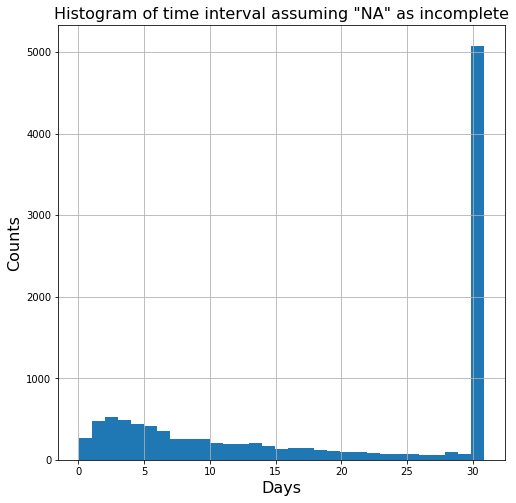

In [16]:
#Plot the histogram

plt.figure(1,figsize=(8,8))
plt.hist(time_diff_days, bins=31)

plt.xlabel('Days',fontsize=16)
plt.ylabel('Counts',fontsize=16)
plt.title('Histogram of time interval assuming "NA" as incomplete',fontsize=16)
plt.grid()
plt.show()


In [17]:
#Calculate the fraction of drivers who take first trip within 30 days of signing up 

In [18]:
count=0

for i in time_diff_days:
    
    if i<=30:
        
        count+=1
        
frac=count/len(time_diff_days)

print("faction is %.4f" %frac)

faction is 0.5468


Based on the caculation above, the fraction is only 54.68%. 

At this point, we change our assumption that, we totally ignore the data with 'NA' in their 'first_complete_timestamp'.

In [19]:
# Ignore the data where the first_complete_timestampis NA

time_diff2=[]

threshold=2592000 # 30 days equivalent to 2592000 seconds

for i in range(len(arr_data)):
    
    if arr_data[i,10]!='NA':
        
        time_diff2.append(int(arr_data[i,10])-int(arr_data[i,4]))
        
        
time_diff_days2=[x / 86400 for x in time_diff2]  # convert to the time difference in days



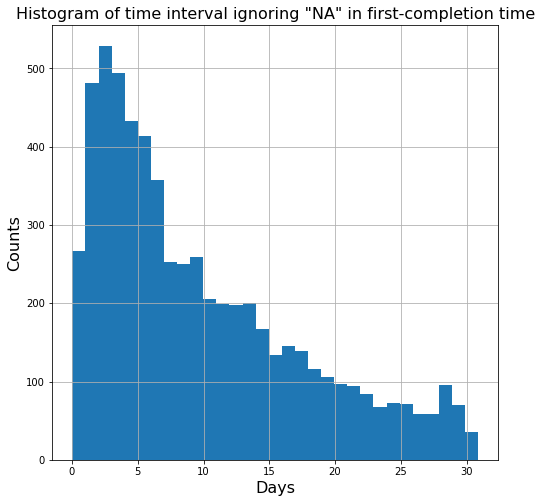

In [20]:
#Plot the histogram

plt.figure(1,figsize=(8,8))
plt.hist(time_diff_days2, bins=31)

plt.xlabel('Days',fontsize=16)
plt.ylabel('Counts',fontsize=16)
plt.title('Histogram of time interval ignoring "NA" in first-completion time',fontsize=16)
plt.grid()
plt.show()


In [21]:
count=0

for i in time_diff_days2:
    
    if i<=30:
        
        count+=1
        
frac=count/len(time_diff_days2)

print("faction is %.4f" %frac)

faction is 0.9954


Here, after ignoring the 'NA' in their 'first_complete_timestamp', the data set has been shortned too much and the fraction 99.54% is abnormally high. Compared with the previous fraction 54.68%, we should still consider 'NA' as not even started instead of ignoring it.

# Part B

To build a predictive model, first I need to slice the datasets into inputs and outputs. Also, I need to continue clean our data and transfer categorical feature of our data into numerical feature. 

In [22]:
# Remove id since it is random and irelevant with our the prediction output 

In [23]:
arr_data1=np.delete(arr_data,0,1)

In [24]:
# Store the different categories of each attributes

In [25]:
city_list=[]

signup_os_list=[]

signup_channel_list=[]

vehicle_make_list=[]

vehicle_model_list=[]

vehicle_year_list=[]

for item in arr_data1:
    
    if item[0] not in city_list:
        
        city_list.append(item[0])
        
    if item[1] not in signup_os_list:
        
        signup_os_list.append(item[1])   
        
    if item[2] not in signup_channel_list:
        
        signup_channel_list.append(item[2])   
        
    if item[6] not in vehicle_make_list:
        
        vehicle_make_list.append(item[6])
        
    if item[7] not in vehicle_model_list:
        
        vehicle_model_list.append(item[7])    
        
    if item[8] not in vehicle_year_list:
        
        vehicle_year_list.append(item[8])         

In [26]:
# Transfer city name into numerical 

In [27]:
city_list

['Strark', 'Berton', 'Wrouver']

We transfer city location into numeric representation, 'Strark' as 1 , 'Berton' as 2 , 'Wrouver'as 3 

In [28]:
for item in arr_data1:
    
    idx=city_list.index(item[0])+1
    
    
    item[0]=idx    

In [29]:
# Analysis of singup_os

In [30]:
signup_os=list(arr_data1[:,1])

In [31]:
NA_count=signup_os.count('NA')

NA_frac=NA_count/len(signup_os)


print('The fraction of NA in signup os is %.4f'%NA_frac )
signup_os_list

The fraction of NA in signup os is 0.4360


['NA', 'ios web', 'other', 'android web', 'windows', 'mac']

Nearly 43.6% of signup os are 'NA', and 'NA' here indiicates unknown because we have 'other' genre. Too many 'NA' make this feature less valuable. So, I will remove this feature from feature set for prediction 

In [32]:
arr_data1=np.delete(arr_data1,1,1)

In [33]:
# Analysis of singup_channel

In [34]:
signup_channel=list(arr_data1[:,1])

NA_count=signup_channel.count('NA')

NA_frac=NA_count/len(signup_channel)


print('The fraction of NA in signup channel is %.4f'%NA_frac )
signup_channel_list

The fraction of NA in signup channel is 0.0992


['R2D', 'Dost', 'Referral', 'NA', 'Organic', 'Paid']

The 'NA' fraction in signup_channel is only 9.92%, I will remove those records, if 'NA' is in their signup channel feature.
Also, I transfer other category into numeric  representation, 'R2D' as 1 ,'Dost' as 2 , 'Referral'as 3 and so on

In [35]:
#Remove 'NA' in the signup_channel_list

signup_channel_list.remove('NA') 



arr_data2=[]

for item in arr_data1:
    
    if item[1]!='NA':
        
        idx=signup_channel_list.index(item[1])+1  # tansfer into numerical
        
        item[1]=idx 
        
        arr_data2.append(item)
        
    
arr_data2=np.array(arr_data2)
        

In [36]:
# Anlysis of signup_timestamp

The feature signup_timestamp itself is not very useful, so we need to use it as a start time point and let other time features substract it. Eventually, we will use time interval to replace timestamp and delete the signup_timestamp feature at last.

In [37]:
#Analysis of BGC date 

In [38]:
bgc_date=list(arr_data2[:,3])

NA_count_bgc=bgc_date.count('NA')

complete_date=list(arr_data2[:,8])

NA_count_complete=complete_date.count('NA')


NA_frac=NA_count_bgc/len(bgc_date)


print('The fraction of NA in bgc date is %.4f'%NA_frac )

The fraction of NA in bgc date is 0.3641


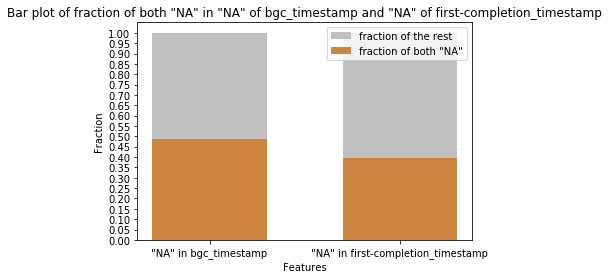

In [39]:
counter=0

for item in arr_data2:
    
    if item[3]=='NA' and item[8]=='NA':
        
        counter+=1
        

frac_bgc=counter/NA_count_bgc

frac_complete=counter/NA_count_complete
        
        
        
#print ('The fraction of both NA in first-completion_timestamp and bgc_date over NA in bgc_date  is %.4f' %float(counter/NA_count))        
    
Features = ['"NA" in bgc_timestamp', '"NA" in first-completion_timestamp']
bronzes = np.array([frac_bgc, frac_complete])
silvers = np.array([1-frac_bgc, 1-frac_complete])
ind = [x for x, _ in enumerate(Features)]

plt.bar(ind, silvers, width=0.6, label='fraction of the rest', color='silver', bottom=bronzes)
plt.bar(ind, bronzes, width=0.6, label='fraction of both "NA"', color='#CD853F')

plt.xticks(ind, Features)
plt.ylabel("Fraction")
plt.xlabel("Features")
plt.yticks(np.arange(0, 1.05, 0.05))
plt.legend(loc="upper right")
plt.title('Bar plot of fraction of both "NA" in "NA" of bgc_timestamp and "NA" of first-completion_timestamp' )

plt.show()       
    




As we see, the fraction of NA in bgc date is very high and I can't remove the feature as I did for signup_os, because the 48.9% of both 'NA' first-completion_timestamp and bgc_date over 'NA' in bgc_data also may indicates the driver did not want to do the background check, consequently, the driver did not initiate her/his first trip either. 

Alternatively, considering the common sense, company usually do not allow drivers to start her/his first trip without the background. Then I will use average time interval betweem signup time and bgc time to replace those records have "NA" in bgc time but not "NA" in first completion time. For the records, which have both "NA" in bgc time and first completion time, I will give a very large value (>>30 days) instead.

In [40]:

sums=0

for item in arr_data2:
    
    if item[3]=='NA':
        
        item[3]=0
        
    else:
        
        item[3]=np.float(np.float(item[3])-np.float(item[2]))/3600  #convert to hours
        

    sums=sums+float(item[3])

avg=(sums)/(len(arr_data2)-NA_count_bgc)    



for item in arr_data2:
    
    if item[3]=='0' and item[8]=='NA':
        
        item[3]= 1000                # large number for both "NA"
        
    if item[3]=='0' and item[8]!='NA': 
        
        item[3]=avg                # use average to replace




    

In [41]:
# Analysis of vehicle added_time

In [42]:
vehicle_addedtime=list(arr_data2[:,4])

vehicle_addedtime.count('NA')

997

Similarly to the bgc_added time, we have only 997 "NA" in vehicle added time, therefore, we will use average time interval from signup time to replace those "NA"

In [43]:
sums=0

for item in arr_data2:
    
    if item[4]=='NA':
        
        item[4]=0      
    else:
        
        item[4]=np.float(np.float(item[4])-np.float(item[2]))/3600  #convert to hours
        

    sums=sums+np.float(item[4])
        
avg=(sums)/(len(arr_data2)-vehicle_addedtime.count('NA'))      

avg

7.656593485198731

In [44]:
# Fill up the NA by the average time interval

In [45]:
for item in arr_data2:
    
    if item[4]=='0':
        
        item[4]= avg

In [46]:
#  The vehicle make and vehicle model analysis

In [47]:
NA_count_make=list(arr_data2[:,5]).count('NA')
NA_count_model=list(arr_data2[:,6]).count('NA')

print('The number of "NA" in vehicle make is %s'% NA_count_make)
print('The number of types of vehicle make is %s'% len(vehicle_make_list) )
print('The number of "NA" in vehicle model is %s'% NA_count_model )
print('The number of types of vehicle model is %s'% len(vehicle_model_list) )

The number of "NA" in vehicle make is 520
The number of types of vehicle make is 48
The number of "NA" in vehicle model is 0
The number of types of vehicle model is 473


Since the "NA" in vehicle model is 0 but types are 473, therefore, we use types of vehicle makes instead. For those "NA", we will use types of model to replace.

In [48]:

new_vehicle_make_list=[]


for item in arr_data2:
    
    if item[5]=='NA':
        
        item[5]=item[6]
        
    if item[5] not in new_vehicle_make_list:
        
        new_vehicle_make_list.append(item[5])
        
    idx=new_vehicle_make_list.index(item[5])+1  # tansfer into numerical
        
    item[5]=idx   

In [49]:
# vehicle year transfer 

To not make the variables too large and model too complex, for vehicle year, we will decrease the whole values by substracting a constant (1992)

In [50]:
for item in arr_data2:
    
    item[7]=int(item[7])-1992

In [51]:
arr_data2

array([['1', '1', '1499398937', ..., 'CC', '20', 'NA'],
       ['2', '2', '1499128867', ..., '4Runner', '11', '1500794810'],
       ['2', '1', '1499752529', ..., 'Elantra', '23', 'NA'],
       ...,
       ['1', '3', '1499653242', ..., 'Impala', '24', '1499909688'],
       ['1', '1', '1500289288', ..., 'RAV4', '23', '1501651662'],
       ['1', '4', '1499490408', ..., 'Elantra', '25', '1499769404']],
      dtype='<U36')

In [52]:
# Transfer the completion time into binary

Just like what I did in part A, since it is prediciton problem for binary classfication. Therefore, For those time are larger than 30 days (includng "NA") it will be labeled as '1' and for the rest, it is in '0'

In [53]:
# Calculate the time difference between complete-time and sign-up time


threshold=2592000 # 30 days equivalent to 2592000 seconds

for i in range(len(arr_data2)):
    
    if arr_data2[i,8]=='NA':
        
        arr_data2[i,8]=1
        
    else:
        
        if int(arr_data2[i,8])-int(arr_data2[i,2])<=threshold:
            
            arr_data2[i,8]=0
            
        else:
            
            arr_data2[i,8]=1        

In [54]:
# Remove signup_time and vehicle_model

In [55]:
arr_data3=np.delete(arr_data2,2,1)

In [56]:
Final_data=np.delete(arr_data3,5,1)

In [57]:
# We shuffle the data set by rows

In [58]:
np.random.shuffle(Final_data)


In [59]:
Final_data=np.array(Final_data) 
Final_data = Final_data.astype(float)


I am going to use 4 different classifiers to see how the predicitions. They are logistics regression, SVM, KNN and DNN.

In [269]:
# Logistics regression

In [60]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Split the data set into 80% for training and 20% for testing
X_train_LR, X_test_LR, y_train_LR, y_test_LR = train_test_split(Final_data[:,0:6], Final_data[:,6], test_size=0.2, random_state=0)

In [331]:
logreg = LogisticRegression(penalty='l2', C=1) # we use l2 norm
logreg.fit(X_train_LR, y_train_LR)
y_pred_LR = logreg.predict(X_test_LR)
print('Accuracy of logistic regression classifier on test set: {:.4f}'.format(logreg.score(X_test_LR, y_test_LR)))

Accuracy of logistic regression classifier on test set: 0.7273


In [332]:
print(confusion_matrix)
print(classification_report(y_test_LR, y_pred_LR))

<function confusion_matrix at 0x000002401CE127B8>
             precision    recall  f1-score   support

        0.0       0.68      0.95      0.79      1105
        1.0       0.88      0.46      0.60       912

avg / total       0.77      0.73      0.71      2017



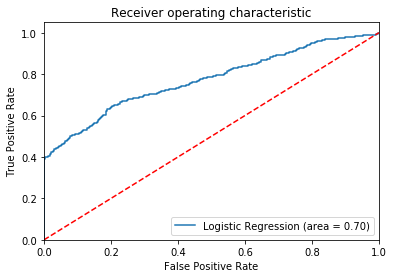

In [272]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test_LR))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test_LR)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [200]:
#Support Vector Machine

In [201]:
from sklearn import svm
from sklearn.svm import SVC

X_train, X_test, y_train, y_test = train_test_split(Final_data[:,0:6], Final_data[:,6], test_size=0.2, random_state=0)

In [204]:
svmclf = svm.SVC(C=1, kernel='rbf', gamma=0.1) #using rbf kernnel since linear kernel make algorithm freeze
svmclf.fit(X_train, y_train)
y_pred = svmclf.predict(X_test)
print('Accuracy of SVM with rbf kernel on test set: {:.4f}'.format(svmclf.score(X_test, y_test)))

Accuracy of SVM with rbf kernel on test set: 0.7238


In [205]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

        0.0       0.69      0.90      0.78      1105
        1.0       0.80      0.52      0.63       912

avg / total       0.74      0.72      0.71      2017



In [206]:
# K-Nearest Neigbors

In [239]:
from sklearn.neighbors import KNeighborsClassifier  

X_train, X_test, y_train, y_test = train_test_split(Final_data[:,0:6], Final_data[:,6], test_size=0.2, random_state=0)

knn = KNeighborsClassifier(n_neighbors=2)  
knn.fit(X_train, y_train)  

y_pred = knn.predict(X_test)
print('Accuracy of knn on test set: {:.4f}'.format(svmclf.score(X_test, y_test)))
print(classification_report(y_test, y_pred))

Accuracy of knn on test set: 0.7238
             precision    recall  f1-score   support

        0.0       0.69      0.90      0.78      1105
        1.0       0.80      0.52      0.63       912

avg / total       0.74      0.73      0.71      2017



In [208]:
#Deep Neural Network

In [240]:
import tensorflow as tf
from tensorflow import keras

In [241]:
X_train, X_test, y_train, y_test = train_test_split(Final_data[:,0:6], Final_data[:,6], test_size=0.2, random_state=0)


In [242]:
# set the structure of DNN

In [243]:
model = keras.Sequential([
    keras.layers.Dense(512, activation=tf.nn.relu),
    keras.layers.Dense(512, activation=tf.nn.relu),
    keras.layers.Dense(256, activation=tf.nn.relu),
    keras.layers.Dense(256, activation=tf.nn.relu),
    keras.layers.Dense(128, activation=tf.nn.relu),

    keras.layers.Dense(2, activation=tf.nn.softmax)
])

In [244]:
model.compile(optimizer='Adam',          # Tuned with other parameter as well, so far this one gives the best.
              loss='mse',
              metrics=['accuracy'])

In [245]:
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
8066/8066 [==============================] - 3s 337us/step - loss: 0.3035 - acc: 0.5260
Epoch 2/10
8066/8066 [==============================] - 2s 224us/step - loss: 0.3009 - acc: 0.4344
Epoch 3/10
8066/8066 [==============================] - 2s 223us/step - loss: 0.3034 - acc: 0.4921
Epoch 4/10
8066/8066 [==============================] - 2s 213us/step - loss: 0.3016 - acc: 0.4638
Epoch 5/10
8066/8066 [==============================] - 2s 216us/step - loss: 0.2999 - acc: 0.4231
Epoch 6/10
8066/8066 [==============================] - 2s 221us/step - loss: 0.2998 - acc: 0.4314
Epoch 7/10
8066/8066 [==============================] - 2s 225us/step - loss: 0.2997 - acc: 0.4120 
Epoch 8/10
8066/8066 [==============================] - 2s 215us/step - loss: 0.2993 - acc: 0.4269
Epoch 9/10
8066/8066 [==============================] - 2s 216us/step - loss: 0.2992 - acc: 0.4200
Epoch 10/10
8066/8066 [==============================] - 2s 211us/step - loss: 0.2991 - acc: 0.4032


In [246]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

2017/2017 [==============================] - 1s 255us/step
Test accuracy: 0.7486365889935548


No handles with labels found to put in legend.


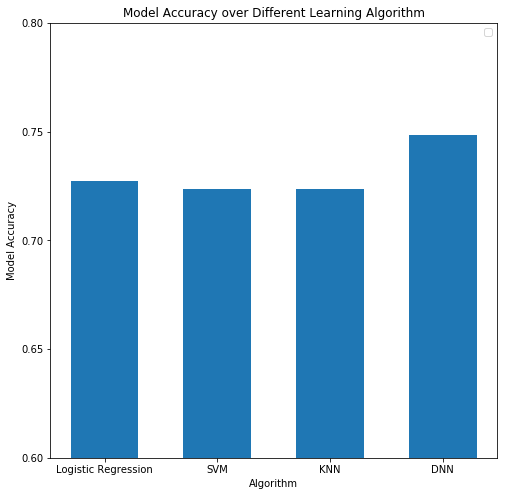

In [262]:
Features = ['Logistic Regression', 'SVM','KNN','DNN']

acc = np.array([0.7273, 0.7238, 0.7238,test_acc])
ind = [x for x, _ in enumerate(Features)]
plt.figure(1,figsize=(8,8))
plt.bar(ind, acc, width=0.6)

plt.xticks(ind, Features)
plt.ylabel("Model Accuracy")
plt.xlabel("Algorithm")
plt.yticks(np.arange(0, 1.05, 0.05))
plt.ylim(0.6, 0.8) 
plt.legend(loc="upper right")
plt.title('Model Accuracy over Different Learning Algorithm' )

plt.show()       
    

As we can see above, the DNN has highest accuracy up to almost 75%, at cost of 5 hiddlen layers and huge computational burdern. The Logistic regression ranked at the second. SVM and KNN are equally third. I think they result make sense, DNN shows it superiority to understand the feature much more deeper after I tunned into right parameter. Because of binary classfication, logistic regression is aimed to solve this problem. 

However, the SVM algorithm got stuck in the first place then I set kernel to be linear, which means linear assumption betweem features and labels are not solid, so linear kernel can't find hyperplane to seperate. After I chose to use rbf kernel and transform the feature into higher dimension, it works at accuracy around 73%

KNN is a lazy learning algorithm, it works very fast for binary classification but somehere it is slightly less accurate than other algorithm.

In all, after clearning the data and transforming into the numerical, we get at least 73% accuracy, which indicates our algorithms do work and DNN is the best.

More importantly, to see how valid the model is, we need to use k fold cross validation. Since it is problem of binary classfication adn we do not know the exact relation between features and labels, so I choose logistic regression among 4 learning algorithm to do k fold cross validation.

In [ ]:
# K-fold cross validation on logistic regression 

In [77]:
from sklearn.model_selection import cross_val_score

logreg = LogisticRegression(penalty='l2', C=1) # we use l2 norm

#I choose K=10
scores = cross_val_score(logreg, X_train_LR, y_train_LR, cv=10) 

avg=sum(scores)/len(scores)                                            

print("The 10-fold cross validation score of logistic regression model is %.4f" %avg)

The 10-fold cross validation score of logistic regression model is 0.7234


# Part C

In [ ]:
#Analysis of one testing result from logistic regression

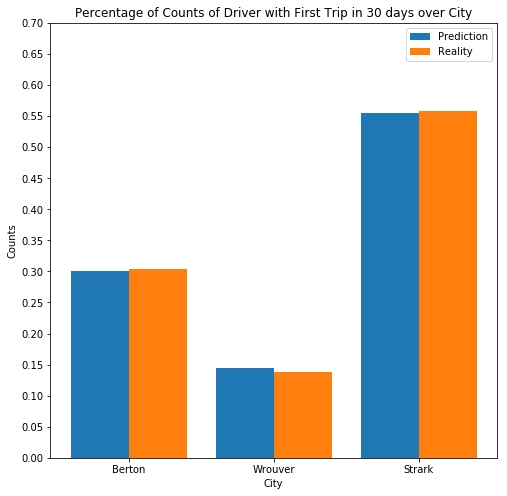

In [363]:
# Location analysis

counter0=0

counter1=0

counter2=0

counter3=0


for i in range(0,len(y_pred_LR)):
    
    if y_pred_LR[i]==0:
        
        counter0+=1
        
        if X_test_LR[i,0]==1:
            
            counter1+=1
            
        if X_test_LR[i,0]==2:
            
            counter2+=1
        
        if X_test_LR[i,0]==3:
            
            counter3+=1
            
            
per1= counter1/counter0          

per2= counter2/counter0  

per3= counter3/counter0  


            
counter0_true=0

counter1_true=0

counter2_true=0

counter3_true=0


for i in range(0,len(y_test_LR)):
    
    if y_test_LR[i]==0:
        
        counter0_true+=1
        
        if X_test_LR[i,0]==1:
            
            counter1_true+=1
            
        if X_test_LR[i,0]==2:
            
            counter2_true+=1
        
        if X_test_LR[i,0]==3:
            
            counter3_true+=1
            
            
per1_true= counter1_true/counter0_true          

per2_true= counter2_true/counter0_true  

per3_true= counter3_true/counter0_true   



            
            


acc = np.array([per1, per2, per3])
acc_true = np.array([per1_true, per2_true, per3_true])
ind = np.array([1,2,3])
plt.figure(1,figsize=(8,8))
drift=0.2
plt.bar(ind-drift, acc, width=2*drift)
plt.bar(ind+drift, acc_true, width=2*drift)

plt.xticks(ind, city_list)
plt.ylabel("Counts")
plt.xlabel("City")
plt.yticks(np.arange(0, 1.05, 0.05))
plt.ylim(0, 0.7) 
plt.title('Percentage of Counts of Driver with First Trip in 30 days over City' )

plt.legend(['Prediction', 'Reality'],loc="upper right")
plt.show()               
        
        

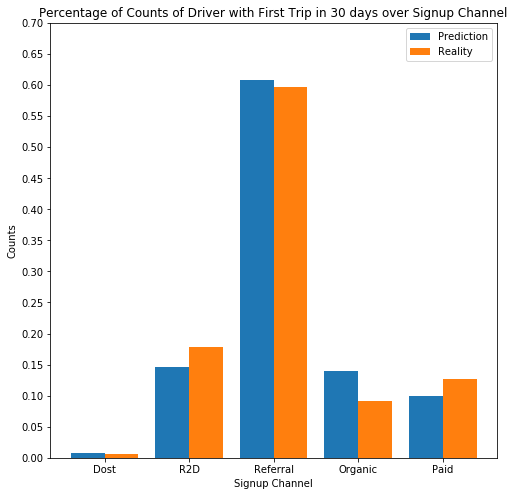

In [370]:
# Signup-channel analysis

 
counter0,counter1,counter2,counter3,counter4,counter5=0,0,0,0,0,0

for i in range(0,len(y_pred_LR)):
    
    if y_pred_LR[i]==0:
        
        counter0+=1
        
        if X_test_LR[i,1]==1:
            
            counter1+=1
            
        if X_test_LR[i,1]==2:
            
            counter2+=1
        
        if X_test_LR[i,1]==3:
            
            counter3+=1
        
        if X_test_LR[i,1]==4:
            
            counter4+=1
            
        if X_test_LR[i,1]==5:
            
            counter5+=1
            
per1= counter1/counter0          

per2= counter2/counter0  

per3= counter3/counter0  

per4= counter4/counter0  

per5= counter5/counter0  


counter0,counter1,counter2,counter3,counter4,counter5=0,0,0,0,0,0


for i in range(0,len(y_test_LR)):
    
    if y_test_LR[i]==0:
        
        counter0+=1
        
        if X_test_LR[i,1]==1:
            
            counter1+=1
            
        if X_test_LR[i,1]==2:
            
            counter2+=1
        
        if X_test_LR[i,1]==3:
            
            counter3+=1
         
        if X_test_LR[i,1]==4:
            
            counter4+=1
            
        if X_test_LR[i,1]==5:
            
            counter5+=1
            
per1_true= counter1/counter0          

per2_true= counter2/counter0  

per3_true= counter3/counter0  

per4_true= counter4/counter0  

per5_true= counter5/counter0  
            
acc = np.array([per1, per2, per3, per4, per5])
acc_true = np.array([per1_true, per2_true, per3_true, per4_true, per5_true])
ind = np.array([1,2,3,4,5])
plt.figure(1,figsize=(8,8))
drift=0.2
plt.bar(ind-drift, acc, width=2*drift)
plt.bar(ind+drift, acc_true, width=2*drift)

plt.xticks(ind, signup_channel_list)
plt.ylabel("Counts")
plt.xlabel("Signup Channel")
plt.yticks(np.arange(0, 1.05, 0.05))
plt.ylim(0, 0.7) 
plt.title('Percentage of Counts of Driver with First Trip in 30 days over Signup Channel' )

plt.legend(['Prediction', 'Reality'],loc="upper right")
plt.show()               
        






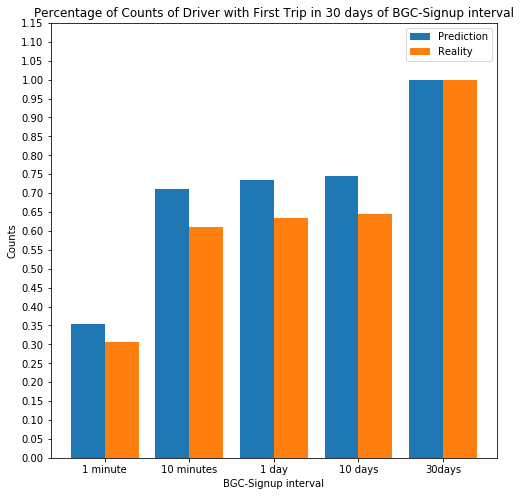

In [384]:
# Bgc-channel analysis

counter0,counter1,counter2,counter3,counter4,counter5=0,0,0,0,0,0

for i in range(0,len(y_pred_LR)):
    
    if y_pred_LR[i]==0:
        
        counter0+=1
        
        if X_test_LR[i,2]<=0.01666:
            
            counter1+=1
            
        if X_test_LR[i,2]<=0.16666:
            
            counter2+=1
        
        if X_test_LR[i,2]<=1:
            
            counter3+=1
        
        if X_test_LR[i,2]<=10:
            
            counter4+=1
            
        if X_test_LR[i,1]<=720:
            
            counter5+=1
            
per1= counter1/counter0          

per2= counter2/counter0  

per3= counter3/counter0  

per4= counter4/counter0  

per5= counter5/counter0  


counter0,counter1,counter2,counter3,counter4,counter5=0,0,0,0,0,0


for i in range(0,len(y_test_LR)):
    
    if y_test_LR[i]==0:
        
        counter0+=1
        
        if X_test_LR[i,2]<=0.01666:
            
            counter1+=1
            
        if X_test_LR[i,2]<=0.16666:
            
            counter2+=1
        
        if X_test_LR[i,2]<=1:
            
            counter3+=1
         
        if X_test_LR[i,2]<=10:
            
            counter4+=1
            
        if X_test_LR[i,2]<=720:
            
            counter5+=1
            
per1_true= counter1/counter0          

per2_true= counter2/counter0  

per3_true= counter3/counter0  

per4_true= counter4/counter0  

per5_true= counter5/counter0  

bgc_time_interval=['1 minute','10 minutes','1 day','10 days', '30days']

acc = np.array([per1, per2, per3, per4, per5])
acc_true = np.array([per1_true, per2_true, per3_true, per4_true, per5_true])
ind = np.array([1,2,3,4,5])
plt.figure(1,figsize=(8,8))
drift=0.2
plt.bar(ind-drift, acc, width=2*drift)
plt.bar(ind+drift, acc_true, width=2*drift)

plt.xticks(ind, bgc_time_interval)
plt.ylabel("Counts")
plt.xlabel("BGC-Signup interval")
plt.yticks(np.arange(0, 1.2, 0.05))
#plt.ylim(0, 1) 
plt.title('Percentage of Counts of Driver with First Trip in 30 days of BGC-Signup interval' )

plt.legend(['Prediction', 'Reality'],loc="upper right")
plt.show()               
        

In [ ]:
# Some idea

According to previous analysis, new signup drivers in Strark are prone to start their trip in first 30 days. The driver from referral starts their first trip much earlier and nearly 75% of drivers who finished background check in 10 days will start their first trip in 30 days.

Based on those 3 features so far, Uber company can do more advertisement in Strark city to hire more drivers. Also, referral system should be encouraged by giving some bonus for both referral and referee. More importantly, considering the background check time interval, we should simlify the background system, because the a lot of 'NA's in the bgc_timestamp features indicates 'NA' in first trip finished time. It means some people are not willing to do background check, so it could make more drivers start their first trip if we make background system much more friendly and accessible.